# Predicting Probability of Iceberg from Satellite Radar Imagery

## Imports and Read Data

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns
# from visuals import plot_examples, plot_3d_example
import matplotlib.gridspec as gridspec
import plotly.graph_objs as go
import plotly.offline as py

py.init_notebook_mode(connected=True)
%matplotlib inline

df = pd.read_json(os.path.join('input', 'train.json'))

Using TensorFlow backend.


## Create Extra Band

In [2]:
from helpers import process_df

# list of convenience
bands = ['band_1', 'band_2', 'band_3']

process_df(df)
df.sample()

Third band added!
inc_angle reclassified as floats with NaNs!


,band_1,band_2,id,inc_angle,is_iceberg,band_3
1158,"[-25.598127, -28.190857, -33.841843, -31.90369...","[-28.576908, -28.576962, -24.544106, -26.17755...",99eeae27,40.4253,0,"[-27.0875175, -28.3839095, -29.1929745, -29.04..."


## Preparing Tensors

## Training Data Distribution

![distribution of `is_iceberg`](capstone_report/train_data_dist.png)

In [3]:
i = df.is_iceberg.value_counts().loc[0]
s = df.is_iceberg.value_counts().loc[1]
print('The classes to predict are fairly balanced, with {ice} icebergs and {ship} ocean-going ships.'.format(ice=i, ship=s))

The classes to predict are fairly balanced, with 851 icebergs and 753 ocean-going ships.


### Missing Incidence Angles

In [4]:
print('There are {} missing entries for incidence angle.'.format(sum(df.inc_angle.isna())))

There are 133 missing entries for incidence angle.


![graph of missing incidence angles](capstone_report/angle_na_count.png)

We must decide how to fill this missing data or to discard them completely. Possibilities include filling with the median, mean, or mode.

An advanced technique would be to predict the incidence angle from the background ocean dBs levels. perhaps with a CNN with convolutional windows of 1x1 or 2x2 over a small subset where the target object is not supposed to be. The background dBs would presumably be subject to weather on the surface affecting the waves, but still possible. 

### Statistics for Incidence Angle

In [5]:
sns.set(context='talk', style='darkgrid')

#### Q-Q Plot for Incidence Angle

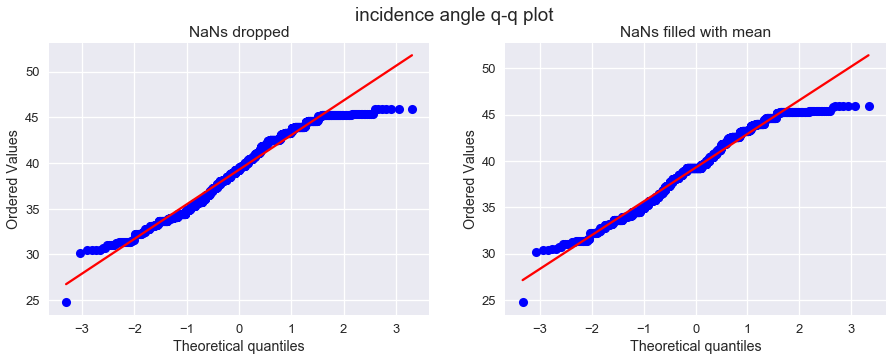

In [6]:
from scipy import stats

dropped_angle = df.inc_angle.dropna().astype(float)
filled_angle = df.inc_angle.fillna(df.inc_angle.mean())

plt.figure(figsize=(15,5))
plt.subplot(121)
stats.probplot(dropped_angle, plot=plt)
plt.title('NaNs dropped')
plt.subplot(122)
stats.probplot(filled_angle, plot=plt)
plt.title('NaNs filled with mean')
plt.suptitle('incidence angle q-q plot')
plt.show()

In [7]:
min_inc_angle_idx = df[df.inc_angle == df.inc_angle.min()].index[0]

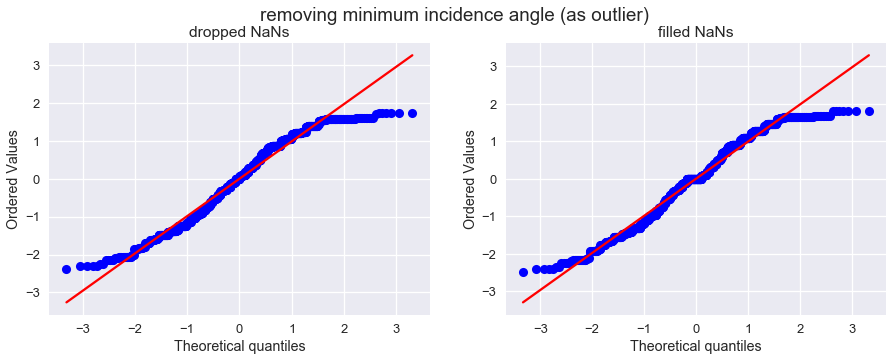

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(121)
stats.probplot(scale(dropped_angle.drop(min_inc_angle_idx)), plot=plt)
plt.title('dropped NaNs')
plt.subplot(122)
stats.probplot(scale(filled_angle.drop(min_inc_angle_idx)), plot=plt)
plt.title('filled NaNs')
plt.suptitle('removing minimum incidence angle (as outlier)')
plt.show()

#### Summary Stats for Incidence Angle

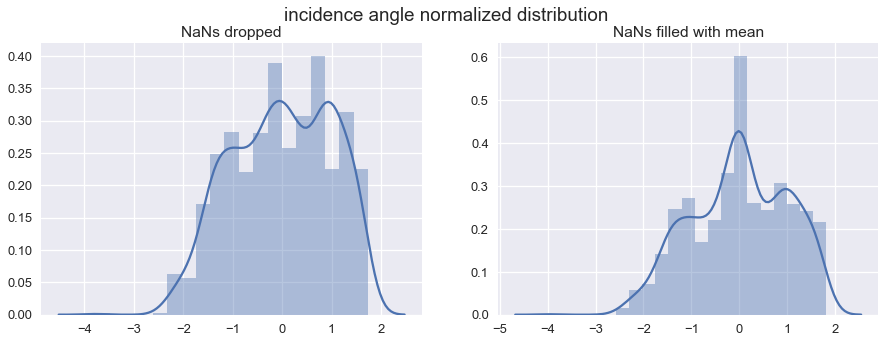

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(121)
na_dropped_angle = df.inc_angle.dropna().astype(float)
sns.distplot(scale(na_dropped_angle));
plt.title('NaNs dropped')
plt.subplot(122)
filled_angle = df.inc_angle.fillna(df.inc_angle.mean())
sns.distplot(scale(filled_angle));
plt.title('NaNs filled with mean')
plt.suptitle('incidence angle normalized distribution')
plt.show()

In [10]:
angle_counts = df.inc_angle.value_counts()
angle_mode = angle_counts.index[0]
angle_mode_count = angle_counts.iloc[0]
print('mode', '{:>15.6f}, count = {}'.format(angle_mode, angle_mode_count))
df.inc_angle.describe()

mode       34.472100, count = 23


count    1471.000000
mean       39.268707
std         3.839744
min        24.754600
25%        36.106100
50%        39.501500
75%        42.559100
max        45.937500
Name: inc_angle, dtype: float64

We choose at this juncture to fill the missing incidence angles with the mean. We also choose to drop the highest and lowest incidence angle entry as an outlier. 

While this might be sub-optimal, it pulls the median lower towards the most frequent value, makes the mean the mode as is the case with a normal distribution, and is a reasonable first guess. 

Note that this changes the incidence angle distribution somewhat substantially. This is necessary if we wish to use as much of the limited training set as possible.

An advanced technique would be to use the `StandardScaler` object of keras to compute scaling statistics and then randomly distribute the `NaN` incidence angles according to the normal distribution calculated. 

In [11]:
filled_df = df.fillna(df.inc_angle.mean())
filled_df.inc_angle = scale(filled_df.inc_angle)
filled_df.drop(min_inc_angle_idx, inplace=True)

## Package and Scale radar bands into 4D tensors

We normalize each band for each image, essentially hoping that each image's decibel's levels can be normalized sufficently. 

In [12]:
def make_tensors(df):
    # for each band, stack the normalized img arrays on top of each other
    norm_band_1 = np.stack(scale(arr) for arr in np.array(df.band_1))
    norm_band_2 = np.stack(scale(arr) for arr in np.array(df.band_2))
    norm_band_3 = np.stack(scale(arr) for arr in np.array(df.band_3))
    # combine the normalized bands into three channels
    flat_tensors = np.stack([norm_band_1, norm_band_2, norm_band_3], axis=-1)
    # return tensors reshaped into 75x75 radar images
    return flat_tensors.reshape(flat_tensors.shape[0], 75, 75, 3)

train_df, valid_df = train_test_split(filled_df, test_size=.125, random_state=42)
train_tensors = make_tensors(train_df)
train_targets = train_df.is_iceberg
train_angle = scale(train_df.inc_angle)
valid_tensors = make_tensors(valid_df)
valid_targets = valid_df.is_iceberg
valid_angle = scale(valid_df.inc_angle)

all_tensors = make_tensors(df)

**Add Bentes Normalization Method Somewhere Here**

In [13]:
print(train_df.shape)
print(valid_df.shape)
print(all_tensors.shape)

(1402, 6)
(201, 6)
(1604, 75, 75, 3)


## Visualize Radar Images

All visualizations are plotted using HH Band 1. 

In [14]:
def get_sample_indices(n=1, iceberg=True):
    ice = 1 if iceberg else 0
    return df[df.is_iceberg == ice].sample(n).index

In [15]:
def plot_examples(n, iceberg=True, idx_list=None, band=1, normed=False):
    assert band in [
        1, 2, 3], 'select either HH band_1 or HV band_2 or mean band_3'
    examples = n
    indices = get_sample_indices(examples, iceberg=iceberg) if idx_list is None else idx_list
    assert len(indices) == n, 'index list length mismatch with number of examples'

    plt.figure(figsize=(15, 5))
    gs = gridspec.GridSpec(examples * 3, examples)
    ex_axes = [plt.subplot(gs[:-1, i]) for i in range(examples)]
    cbar_ax = [plt.subplot(gs[-1, i]) for i in range(examples)]

    for i, idx in enumerate(indices):
        if normed:
            sample = all_tensors[idx,:,:,band-1]
        else:
            sample = np.array(getattr(df, 'band_' + str(band)).iloc[idx]).reshape(75, 75)
        heatmap_kws = dict(
            center=0 if normed else None,
            square=True,
            xticklabels=False,
            yticklabels=False,
            ax=ex_axes[i],
            cmap=sns.color_palette('RdBu_r' if iceberg else 'PuBuGn', 150),
            cbar=True,
            cbar_ax=cbar_ax[i],
            cbar_kws={"orientation": "horizontal",
                      "label": "Normalized dB" if normed else "dB"}
        )
        sns.heatmap(sample, **heatmap_kws)
        angle = df.inc_angle.iloc[idx]
        ex_axes[i].set_title(
            'id: {} | inc_angle = {:.3f}'.format(df.loc[idx].id, angle))

    gs.tight_layout(plt.gcf())
    plt.suptitle('ICEBERGS' if iceberg else 'SHIPS')
    plt.show()
    return indices

In [16]:
def plot_3d_example(band_data, name):
    # visualization code snippet from:
    # https://www.kaggle.com/devm2024/keras-model-for-beginners-0-210-on-lb-eda-r-d
    surface = go.Surface(
        z=np.array(band_data).reshape(75,75),
        colorbar={'title': 'dB'}
    )
    data = [surface]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename=name)

### Icebergs

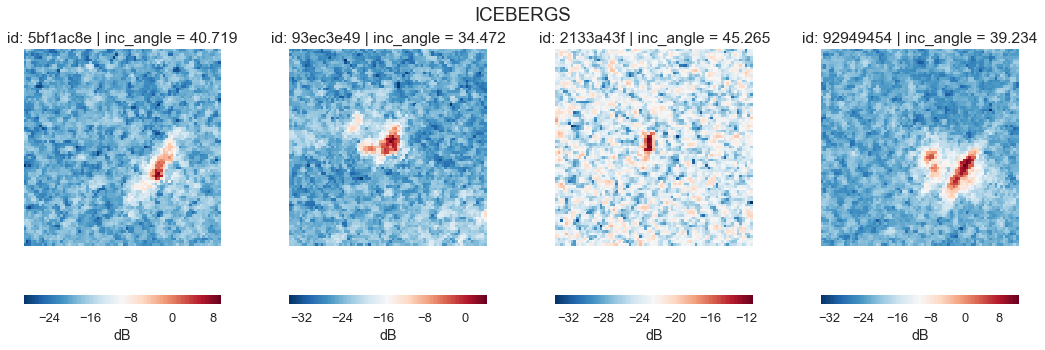

In [17]:
ice_idx = plot_examples(4)

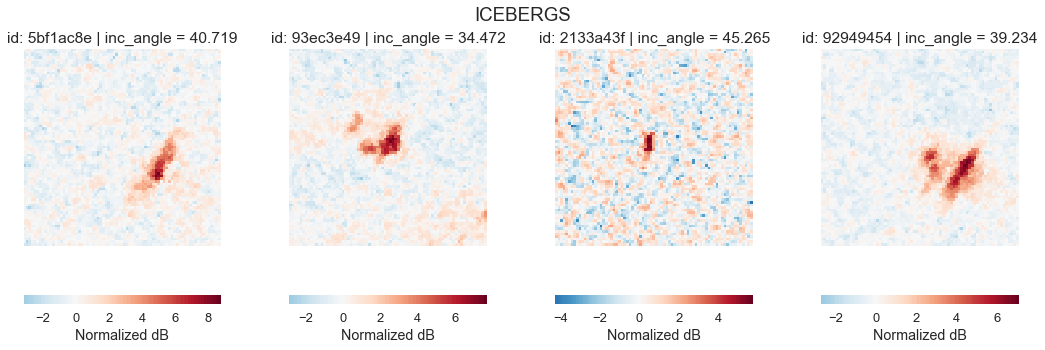

In [18]:
plot_examples(4, idx_list=ice_idx, normed=True);

In [19]:
from random import choice
ice_ex = choice(ice_idx)
plot_3d_example(df.band_1.iloc[ice_ex], 'iceberg_{}'.format(df.id.iloc[ice_ex]))

### Ships

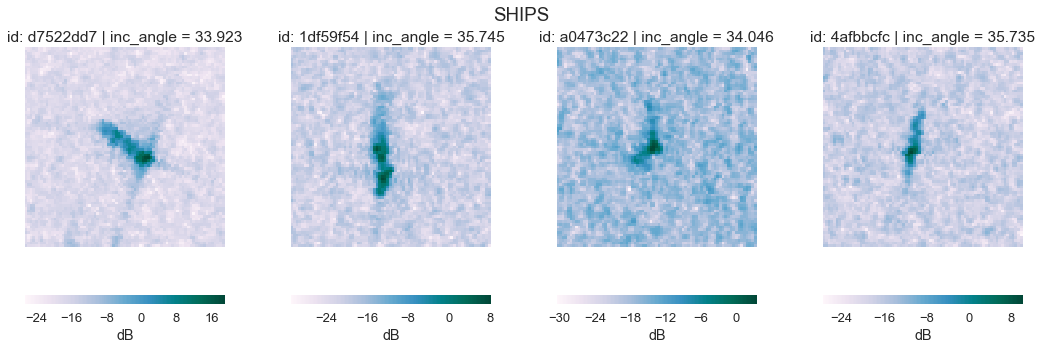

In [20]:
ship_idx = plot_examples(4, iceberg=False)

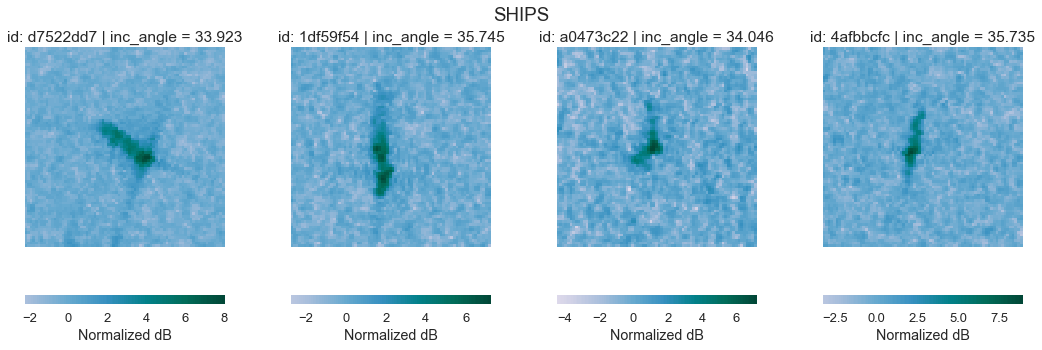

In [21]:
plot_examples(4, iceberg=False, idx_list=ship_idx, normed=True);

In [22]:
ship_ex = choice(ship_idx)
plot_3d_example(df.band_1.iloc[ship_ex], 'ship_{}'.format(df.id.iloc[ship_ex]))

## Set Batch Size for Training

In [23]:
batch_size = 16

## Augment Dataset

In [24]:
from keras.preprocessing.image import ImageDataGenerator

### Set options for training image data generator

In [25]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=.1, 
    height_shift_range=.1, 
    rotation_range=45,
    zoom_range=.1,
    fill_mode='wrap'
)

### Expand keras ImageDataGenerator functionality to handle multiple inputs

In [26]:
import itertools


def take(n, iterable):
    """Return first n items of the iterable as a list"""
    return list(itertools.islice(iterable, n))


def img_and_aux_gen(datagen, tensors, aux_input, targets=None, batch_size=batch_size, shuffle=True):
    # inspired by the following Kaggle notebook
    # https://www.kaggle.com/sinkie/keras-data-augmentation-with-multiple-inputs
    assert len(tensors) == len(aux_input)
    assert len(tensors) == len(targets) if targets is not None else True
    if targets is not None:
        if shuffle:
            flat_tensors = tensors.reshape(tensors.shape[0], 75*75*3)
            aux_input_col = aux_input.reshape(aux_input.shape[0], 1)
            targets_col = targets.reshape(targets.shape[0], 1)
            Z = np.concatenate((flat_tensors, aux_input_col, targets_col), axis=1)
            np.random.shuffle(Z)
            shuffled_targets = Z[:, -1]
            shuffled_aux_inputs = Z[:, -2]
            shuffled_tensors = Z[:, :-2].reshape(tensors.shape)
            img_gen = datagen.flow(x=shuffled_tensors, y=shuffled_targets, batch_size=batch_size, shuffle=False)
            aux_gen = itertools.cycle(shuffled_aux_inputs)
        else:
            img_gen = datagen.flow(x=tensors, y=targets, batch_size=batch_size, shuffle=False)
            aux_gen = itertools.cycle(aux_input)
        while True:
            x1, y = next(img_gen)
            x2 = np.array(take(len(x1), aux_gen))
            yield ([x1, x2], y)
    else:
        gen = datagen.flow(x=tensors, y=aux_input, batch_size=1, shuffle=False)
        while True:
            x1, x2 = next(gen)
            yield ([x1, x2], )
            
def test_gen(tensors_to_test, aux_input, targets=None):
    return img_and_aux_gen(ImageDataGenerator(), tensors_to_test, aux_input, targets)

### Create Multi-Input Training and Validation Generators

In [27]:
train_flow = img_and_aux_gen(train_datagen, train_tensors, train_angle, train_targets)
valid_flow = test_gen(valid_tensors, valid_angle, targets=valid_targets)

These generators will ensure a smooth augmentation strategy while allowing for similar validation flow.

## Model Building 

### Functions to Create Layer Blocks 

In [28]:
from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalMaxPool2D
from keras.layers import Input, Flatten, concatenate, Activation
from keras.layers import Dropout, BatchNormalization
from keras.models import Model

In [29]:
def BatchNorm_Activation_block(y, activation):
    y = BatchNormalization()(y)
    y = Activation(activation)(y)
    return y

def Convolutional_block(y, n_filters, activation, n_Conv=1, drop_rate=0, is_last=False):
    for _ in range(n_Conv):
        y = Conv2D(n_filters, 3)(y)
        if 0 < drop_rate < 1: 
            y = Dropout(drop_rate)(y)
        y = BatchNorm_Activation_block(y, activation)
    return y

def Dense_block(y, units, activation, drop_rate=.5):
    y = Dense(units)(y)
    y = BatchNorm_Activation_block(y, activation)
    if 0 < drop_rate < 1:
        y = Dropout(drop_rate)(y)
    return y

def SAF_pooling(y, drop_rate=.5):
    return Dropout(drop_rate)(MaxPooling2D(2)(y))

def get_inputs():
    radar_img_shape = all_tensors.shape[1:]
    radar_input = Input(shape=radar_img_shape, name='radar_image')
    aux_input = Input(shape=(1,), name='aux_input')
    return radar_input, aux_input

### SimpNet CNN Architecture

Please see [Towards Principled Design of Deep Convolutional Networks: Introducing SimpNet](https://arxiv.org/pdf/1802.06205.pdf) for more information about the architecture (page 9) and motivation.

In [81]:
def build_SimpNet(act='relu', cnn_drop_rate=0, fc_drop_rate=.5):
    # inputs
    radar_input, aux_input = get_inputs()
    
    
    # SimpNet CNN architecture
    x = Convolutional_block(radar_input, 66, act, drop_rate=cnn_drop_rate)
    x = Convolutional_block(x, 128, act, n_Conv=3, drop_rate=cnn_drop_rate)
    x = Convolutional_block(x, 192, act, drop_rate=cnn_drop_rate)
    x = SAF_pooling(x)
    x = Convolutional_block(x, 192, act, n_Conv=4, drop_rate=cnn_drop_rate)
    x = Convolutional_block(x, 288, act, drop_rate=cnn_drop_rate)
    x = SAF_pooling(x)
    x = Convolutional_block(x, 288, act, drop_rate=cnn_drop_rate)
    x = Convolutional_block(x, 355, act, drop_rate=cnn_drop_rate)
    x = Convolutional_block(x, 432, act, drop_rate=cnn_drop_rate)
    radar_output = GlobalMaxPool2D()(x)
    
    # concatenate aux input
    combined = concatenate([radar_output, aux_input])
    
    # short FC layers
    x = Dense_block(combined, 1024, act, drop_rate=fc_drop_rate)
    x = Dense_block(x, 1024, act, drop_rate=fc_drop_rate)
    output = Dense(1, activation='sigmoid', name='is_iceberg')(x)
    
    # model definition and summary
    model = Model([radar_input, aux_input], output, name='SimpNet')
    model.summary()
    # plot_model(model, to_file='cnn-simpnet.png')
    
    return model

In [82]:
# Define callbacks and pretty progress bars
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras_tqdm import TQDMNotebookCallback 

def create_callbacks(version, name):
    # save best model checkpoint
    cnn_name = 'cnn.{}.v{}.best.weights.hdf5'.format(name, version)
    try:
        os.mkdir('saved_models')
    except FileExistsError:
        pass
    save_best = ModelCheckpoint(filepath=os.path.join('saved_models', cnn_name), 
                                save_best_only=True, save_weights_only=True, verbose=1)
    # early stopping 
    early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=10)
    
    # reduce learning rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

    # pretty progress bars
    pbar = TQDMNotebookCallback(leave_inner=True, leave_outer=True)
    
    return {'early_stop': early_stop, 'save_best': save_best, 'reduce_lr': reduce_lr, 'pbar': pbar}

#### Version Number Marker

In [83]:
version = 5

### Create Callbacks

In [84]:
callbacks = create_callbacks(version, 'simpnet')
callback_list = list(callbacks.values())

## Model Creation

The flag `icebergs` is a remnant from a failed experiment to predict the incidence angle from the whole image. This I realize would obviously fail, as a CNN recognizes shapes in the image, and couldn't by the intensity of those shapes necessarily predict a viewing angle. 

Other approaches are necessary, but I keep the compilation keywords for reuse/posterity.

In [85]:
icebergs = True
if icebergs:
    compile_kwargs = {'loss': 'binary_crossentropy', 
                      'optimizer': 'adam', 
                      'metrics': ['accuracy']}
else:
    compile_kwargs = {'loss': 'mse', 'optimizer': 'adam', 'metrics': ['mae']}
# model = build_cnn(iceberg_predict=icebergs)
model = build_SimpNet()
model.compile(**compile_kwargs)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
radar_image (InputLayer)        (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 73, 73, 66)   1848        radar_image[0][0]                
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 73, 73, 66)   264         conv2d_53[0][0]                  
__________________________________________________________________________________________________
activation_65 (Activation)      (None, 73, 73, 66)   0           batch_normalization_65[0][0]     
__________________________________________________________________________________________________
conv2d_54 

## Gather Fit Parameters

In [86]:
epochs = 100
desired_training_size = 3200
steps_per_epoch = int(desired_training_size/batch_size+.5)
for stat, num in zip(['batch size', 'steps per epoch', 'training tensors size'], [batch_size, steps_per_epoch, steps_per_epoch*batch_size]):
    print('{:23} = {}'.format(stat, num))

batch size              = 16
steps per epoch         = 200
training tensors size   = 3200


## Fit the Model to the Data

In [87]:
model.fit_generator(train_flow, 
                    steps_per_epoch=steps_per_epoch, # number of batches of training samples per epoch
                    epochs=epochs,
                    validation_data=valid_flow, 
                    validation_steps=len(valid_tensors),
                    callbacks=callback_list,
                    workers=8,
                    verbose=0);

HBox(children=(IntProgress(value=0, description='Training'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=200), HTML(value='')))


Epoch 00001: val_loss improved from inf to 2.64722, saving model to saved_models\cnn.simpnet.v5.best.weights.hdf5


HBox(children=(IntProgress(value=0, description='Epoch 1', max=200), HTML(value='')))


Epoch 00002: val_loss improved from 2.64722 to 0.82982, saving model to saved_models\cnn.simpnet.v5.best.weights.hdf5


HBox(children=(IntProgress(value=0, description='Epoch 2', max=200), HTML(value='')))


Epoch 00003: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 3', max=200), HTML(value='')))


Epoch 00004: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 4', max=200), HTML(value='')))


Epoch 00005: val_loss improved from 0.82982 to 0.63437, saving model to saved_models\cnn.simpnet.v5.best.weights.hdf5


HBox(children=(IntProgress(value=0, description='Epoch 5', max=200), HTML(value='')))


Epoch 00006: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 6', max=200), HTML(value='')))


Epoch 00007: val_loss improved from 0.63437 to 0.37178, saving model to saved_models\cnn.simpnet.v5.best.weights.hdf5


HBox(children=(IntProgress(value=0, description='Epoch 7', max=200), HTML(value='')))


Epoch 00008: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 8', max=200), HTML(value='')))


Epoch 00009: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 9', max=200), HTML(value='')))


Epoch 00010: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 10', max=200), HTML(value='')))


Epoch 00011: val_loss did not improve

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


HBox(children=(IntProgress(value=0, description='Epoch 11', max=200), HTML(value='')))


Epoch 00012: val_loss improved from 0.37178 to 0.36019, saving model to saved_models\cnn.simpnet.v5.best.weights.hdf5


HBox(children=(IntProgress(value=0, description='Epoch 12', max=200), HTML(value='')))


Epoch 00013: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 13', max=200), HTML(value='')))


Epoch 00014: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 14', max=200), HTML(value='')))


Epoch 00015: val_loss improved from 0.36019 to 0.30432, saving model to saved_models\cnn.simpnet.v5.best.weights.hdf5


HBox(children=(IntProgress(value=0, description='Epoch 15', max=200), HTML(value='')))


Epoch 00016: val_loss improved from 0.30432 to 0.30365, saving model to saved_models\cnn.simpnet.v5.best.weights.hdf5


HBox(children=(IntProgress(value=0, description='Epoch 16', max=200), HTML(value='')))


Epoch 00017: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 17', max=200), HTML(value='')))


Epoch 00018: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 18', max=200), HTML(value='')))


Epoch 00019: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 19', max=200), HTML(value='')))


Epoch 00020: val_loss did not improve

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


HBox(children=(IntProgress(value=0, description='Epoch 20', max=200), HTML(value='')))


Epoch 00021: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 21', max=200), HTML(value='')))


Epoch 00022: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 22', max=200), HTML(value='')))


Epoch 00023: val_loss did not improve

Epoch 00023: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


HBox(children=(IntProgress(value=0, description='Epoch 23', max=200), HTML(value='')))


Epoch 00024: val_loss improved from 0.30365 to 0.30282, saving model to saved_models\cnn.simpnet.v5.best.weights.hdf5


HBox(children=(IntProgress(value=0, description='Epoch 24', max=200), HTML(value='')))


Epoch 00025: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 25', max=200), HTML(value='')))


Epoch 00026: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 26', max=200), HTML(value='')))


Epoch 00027: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 27', max=200), HTML(value='')))


Epoch 00028: val_loss did not improve

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.


HBox(children=(IntProgress(value=0, description='Epoch 28', max=200), HTML(value='')))


Epoch 00029: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 29', max=200), HTML(value='')))


Epoch 00030: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 30', max=200), HTML(value='')))


Epoch 00031: val_loss did not improve

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.


HBox(children=(IntProgress(value=0, description='Epoch 31', max=200), HTML(value='')))


Epoch 00032: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 32', max=200), HTML(value='')))


Epoch 00033: val_loss did not improve


HBox(children=(IntProgress(value=0, description='Epoch 33', max=200), HTML(value='')))


Epoch 00034: val_loss did not improve

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Epoch 00034: early stopping



## Make Predictions on Test Data

### Prepare Test Tensors and Incidence Angles

In [88]:
test_df = pd.read_json(os.path.join('input', 'test.json'))
process_df(test_df)
test_tensors = make_tensors(test_df)
test_angle = scale(test_df.inc_angle.values)

Third band added!
inc_angle already all floats


### Load Trained Model Weights

In [89]:
model.load_weights(os.path.join('saved_models', 'cnn.{}.v{}.best.weights.hdf5'.format('simpnet', version)))

### Generate predictions

In [90]:
preds = model.predict([test_tensors, test_angle])

### Training Set Stats

In [91]:
train_eval = model.evaluate([np.delete(all_tensors, min_inc_angle_idx, axis=0), 
                             scale(filled_df.inc_angle.values)], 
                            filled_df.is_iceberg.values)

1603/1603 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 5s 3ms/step


In [92]:
print('metrics on training set'.center(40, '-'))
print(model.loss.ljust(len(model.loss)+5), '=', round(train_eval[0], 6))
print(model.metrics[0].ljust(len(model.loss)+5), '=', '{:2.3f}%'.format(train_eval[1]*100))

--------metrics on training set---------
binary_crossentropy      = 0.286996
accuracy                 = 87.461%


### Distribution of iceberg probability predictions

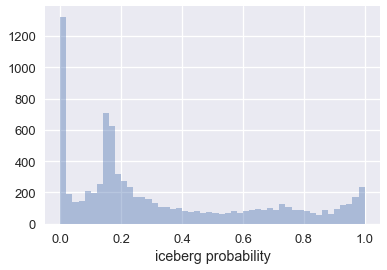

In [93]:
x_label = 'iceberg probability'
ax = sns.distplot(preds, axlabel=x_label, label='TEST', bins=50, kde=False)

## Package submission

In [95]:
submission = pd.DataFrame({'id': test_df.id, 'is_iceberg': preds.reshape(preds.shape[0])})
submission.head(10)
csv_name = 'simpnet_cnn_scale_angle_more_augmentation_v{}.csv'.format(version)
submission.to_csv(os.path.join('output', csv_name), index=False)

# Improve and Iterate

In [97]:
bentes_version = 0

In [98]:
model_name = 'simpnet_bentes_v{}'.format(bentes_version)

In [99]:
16.3468*.8 + 16.521*.2

16.381640000000004